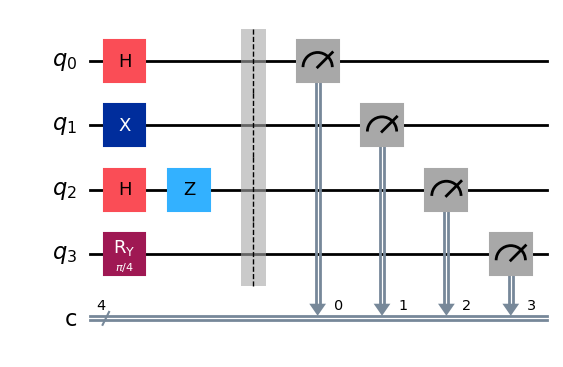

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from numpy import pi
import math

# Build the 4-qubit "PARV" circuit
def build_parv_circuit(measure: bool = True) -> QuantumCircuit:
    """
    q0 -> P: |+>   = H|0>
    q1 -> A: |1>   = X|0>
    q2 -> R: |->   = ZH|0>
    q3 -> V: state from Ry(pi/4)|0>
    """
    if measure:
        qc = QuantumCircuit(4, 4)
    else:
        qc = QuantumCircuit(4)

    # P : q0 in |+>
    qc.h(0)

    # A : q1 in |1>
    qc.x(1)

    # R : q2 in |->
    qc.h(2)
    qc.z(2)

    # V : q3 in rotated state
    qc.ry(pi / 4, 3)

    if measure:
        qc.barrier()
        qc.measure(range(4), range(4))

    return qc

qc_parv = build_parv_circuit(measure=True)
qc_parv.draw("mpl")


In [10]:
import math 
def marginal_probs(counts, bit_index, num_qubits=4):
    """
    Get P(0) and P(1) for a given qubit index.
    bit_index: 0 for q0 (right-most), 1 for q1, ..., 3 for q3.
    counts keys are strings like 'b3b2b1b0'.
    """
    p0 = p1 = 0.0
    total = sum(counts.values())
    for bitstring, c in counts.items():
        bit = bitstring[num_qubits - 1 - bit_index]  # map index to position
        if bit == "0":
            p0 += c
        else:
            p1 += c
    return p0 / total, p1 / total


# Theoretical ideal probabilities for each qubit
ideal = {
    "P (q0)": (0.5, 0.5),                               # |+>
    "A (q1)": (0.0, 1.0),                               # |1>
    "R (q2)": (0.5, 0.5),                               # |->
    "V (q3)": (math.cos(pi/8)**2, math.sin(pi/8)**2),   # Ry(pi/4)
}
labels = ["P (q0)", "A (q1)", "R (q2)", "V (q3)"]


=== IDEAL SIMULATOR COUNTS ===
{'0010': 868, '1111': 147, '1010': 135, '1110': 164, '0011': 896, '1011': 151, '0111': 854, '0110': 881}


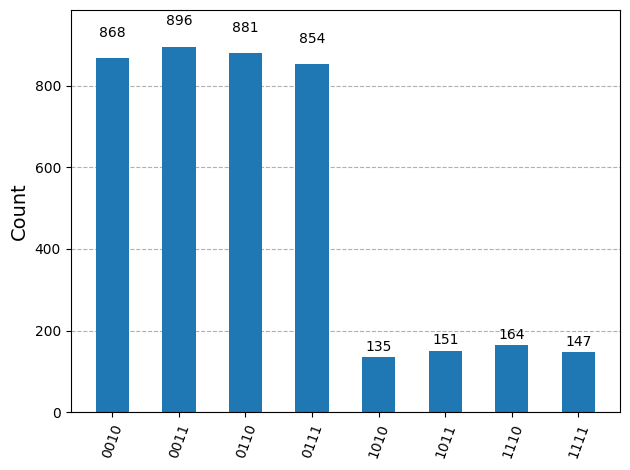

In [11]:
backend_sim = Aer.get_backend("aer_simulator")
shots = 4096

t_qc_sim = transpile(qc_parv, backend_sim)
job_sim = backend_sim.run(t_qc_sim, shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts()

print("=== IDEAL SIMULATOR COUNTS ===")
print(counts_sim)
plot_histogram(counts_sim)


In [12]:
print("\n=== IDEAL vs SIMULATOR (noiseless) ===\n")
for i, label in enumerate(labels):
    p0, p1 = marginal_probs(counts_sim, i, num_qubits=4)
    ideal0, ideal1 = ideal[label]
    print(f"{label}:")
    print(f"  ideal   P(0)={ideal0:.3f}, P(1)={ideal1:.3f}")
    print(f"  sim     P(0)={p0:.3f}, P(1)={p1:.3f}")
    print()



=== IDEAL vs SIMULATOR (noiseless) ===

P (q0):
  ideal   P(0)=0.500, P(1)=0.500
  sim     P(0)=0.500, P(1)=0.500

A (q1):
  ideal   P(0)=0.000, P(1)=1.000
  sim     P(0)=0.000, P(1)=1.000

R (q2):
  ideal   P(0)=0.500, P(1)=0.500
  sim     P(0)=0.500, P(1)=0.500

V (q3):
  ideal   P(0)=0.854, P(1)=0.146
  sim     P(0)=0.854, P(1)=0.146



In [13]:
service = QiskitRuntimeService()   # warning about default instance is OK

print("Backends:")
for backend in service.backends():
    print("-", backend.name, "| simulator:", backend.simulator, "| qubits:", backend.num_qubits)

# Pick one explicitly, e.g. ibm_fez
backend_hw = service.backend("ibm_fez")   # or "ibm_marrakesh" / "ibm_torino"
print("\nUsing hardware backend:", backend_hw.name)


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-29 08:38:37,726: Default instance not set. Searching all available instances.


Backends:
- ibm_fez | simulator: False | qubits: 156
- ibm_marrakesh | simulator: False | qubits: 156
- ibm_torino | simulator: False | qubits: 133

Using hardware backend: ibm_fez


Transpiled circuit ready:


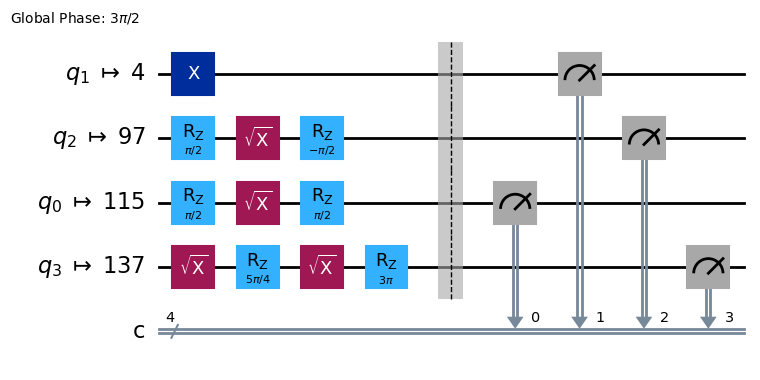

Job ID: d4lb4b43tdfc73dpa0u0
Job status: QUEUED

=== HARDWARE COUNTS ===
{'0011': 848, '0111': 921, '0010': 797, '0110': 872, '1011': 163, '1010': 133, '1111': 152, '1110': 169, '0000': 11, '1100': 1, '0001': 6, '0100': 6, '1101': 3, '0101': 12, '1001': 2}
Original circuit:


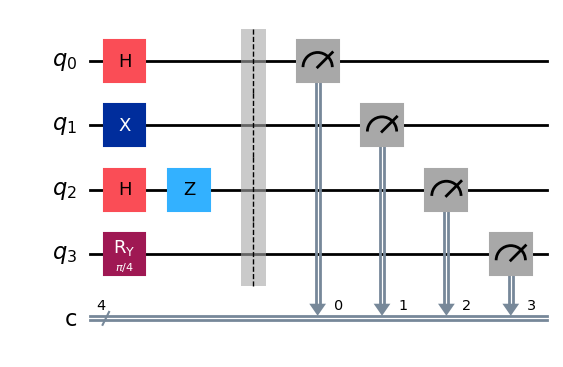

Transpiled circuit for hardware:


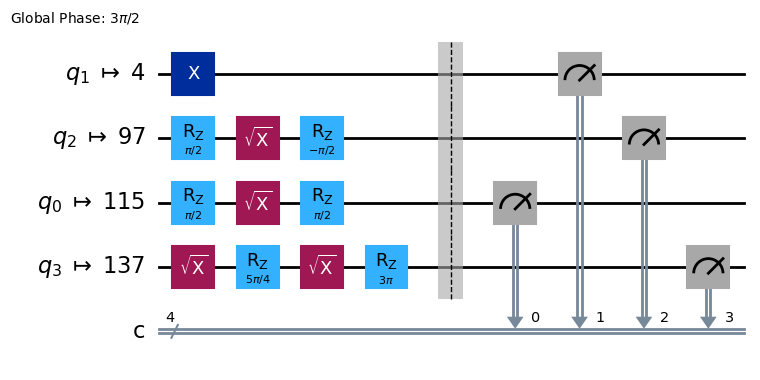

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile
from qiskit.visualization import plot_histogram

qc_parv_hw = build_parv_circuit(measure=True)

qc_parv_hw_transpiled = transpile(qc_parv_hw, backend_hw)

print("Transpiled circuit ready:")
display(qc_parv_hw_transpiled.draw("mpl"))

sampler = Sampler(mode=backend_hw)
shots = 4096

job_hw = sampler.run([qc_parv_hw_transpiled], shots=shots)
print("Job ID:", job_hw.job_id())
print("Job status:", job_hw.status())

result_hw = job_hw.result()
pub_result = result_hw[0]
counts_hw = pub_result.join_data().get_counts()

print("\n=== HARDWARE COUNTS ===")
print(counts_hw)
plot_histogram(counts_hw)

print("Original circuit:")
display(qc_parv_hw.draw("mpl"))

print("Transpiled circuit for hardware:")
display(qc_parv_hw_transpiled.draw("mpl"))



In [18]:
print("\n=== IDEAL vs HARDWARE (PARV) ===\n")

for i, label in enumerate(labels):
    # i = 0 -> q0 (P), 1 -> q1 (A), 2 -> q2 (R), 3 -> q3 (V)
    p0_hw, p1_hw = marginal_probs(counts_hw, i, num_qubits=4)
    ideal0, ideal1 = ideal[label]

    print(f"{label}:")
    print(f"  ideal   P(0)={ideal0:.3f}, P(1)={ideal1:.3f}")
    print(f"  device  P(0)={p0_hw:.3f}, P(1)={p1_hw:.3f}")
    print(f"  |ΔP(0)|={abs(p0_hw-ideal0):.3f}, |ΔP(1)|={abs(p1_hw-ideal1):.3f}")
    print()



=== IDEAL vs HARDWARE (PARV) ===

P (q0):
  ideal   P(0)=0.500, P(1)=0.500
  device  P(0)=0.486, P(1)=0.514
  |ΔP(0)|=0.014, |ΔP(1)|=0.014

A (q1):
  ideal   P(0)=0.000, P(1)=1.000
  device  P(0)=0.010, P(1)=0.990
  |ΔP(0)|=0.010, |ΔP(1)|=0.010

R (q2):
  ideal   P(0)=0.500, P(1)=0.500
  device  P(0)=0.479, P(1)=0.521
  |ΔP(0)|=0.021, |ΔP(1)|=0.021

V (q3):
  ideal   P(0)=0.854, P(1)=0.146
  device  P(0)=0.848, P(1)=0.152
  |ΔP(0)|=0.006, |ΔP(1)|=0.006



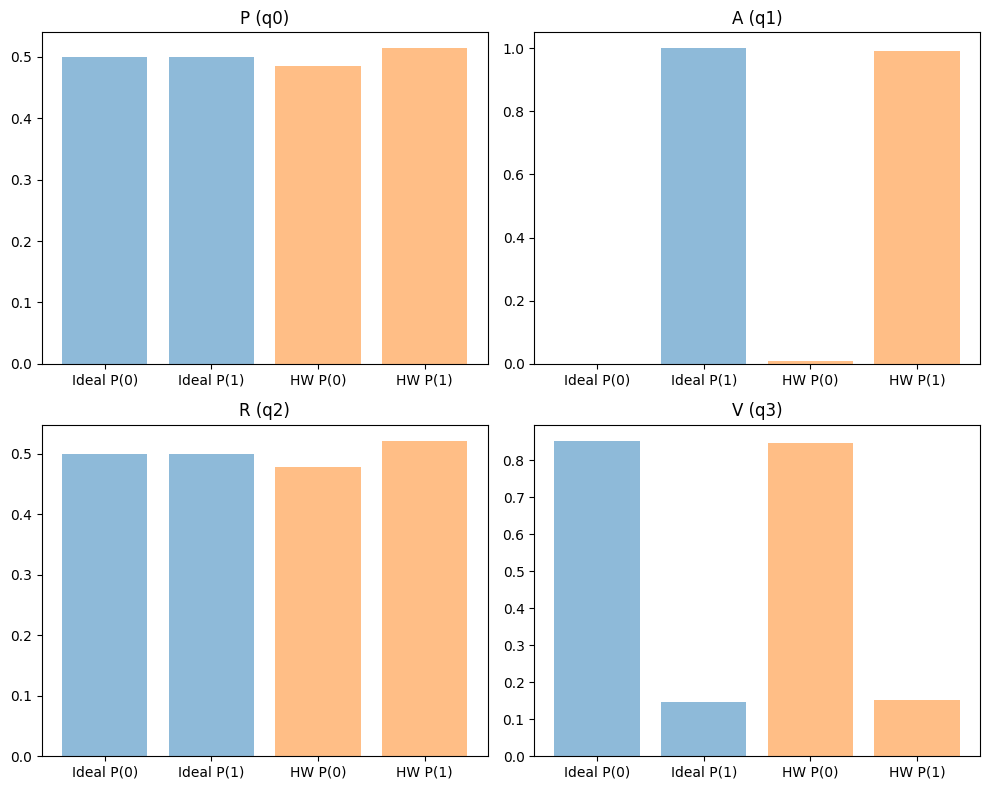

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    p0_i, p1_i = ideal[label]
    p0_h, p1_h = marginal_probs(counts_hw, i)
    ax.bar(["Ideal P(0)","Ideal P(1)"], [p0_i, p1_i], alpha=0.5)
    ax.bar(["HW P(0)","HW P(1)"], [p0_h, p1_h], alpha=0.5)
    ax.set_title(label)

plt.tight_layout()
plt.show()


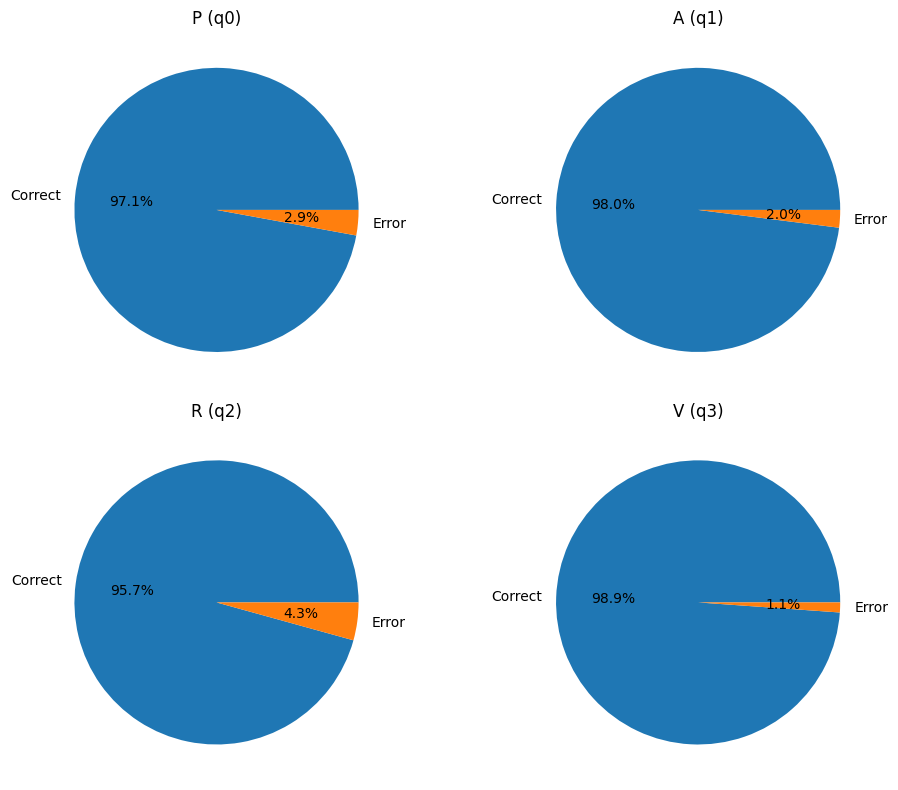

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    p0_h, p1_h = marginal_probs(counts_hw, i)
    p0_i, p1_i = ideal[label]
    err = abs(p0_h - p0_i) + abs(p1_h - p1_i)
    err = min(err,1.0)
    correct = 1 - err
    ax.pie([correct, err], labels=["Correct","Error"], autopct="%1.1f%%")
    ax.set_title(label)

plt.tight_layout()
plt.show()


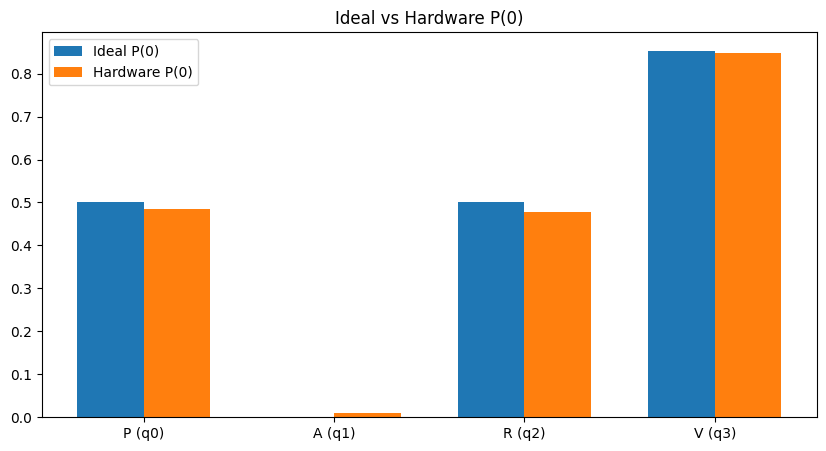

In [23]:
ideal_vals0 = [ideal[l][0] for l in labels]
hw_vals0 = [marginal_probs(counts_hw, i)[0] for i in range(4)]

plt.figure(figsize=(10,5))
x = range(4)
w = 0.35
plt.bar([p - w/2 for p in x], ideal_vals0, width=w, label="Ideal P(0)")
plt.bar([p + w/2 for p in x], hw_vals0, width=w, label="Hardware P(0)")
plt.xticks(x, labels)
plt.legend()
plt.title("Ideal vs Hardware P(0)")
plt.show()
